In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Loading the Datasets

### Load profile

In [2]:
# Load the dataset
load = pd.read_csv('Netze-Strom-Lastprofil-SH0_2024 (2).csv', sep=';')

# Convert 'Profilwert' from German decimal comma to float (optional)
load['Profilwert'] = load['Profilwert'].str.replace(',', '.').astype(float)

# Combine date and time into a new Datetime column and set as index
load['Datetime'] = pd.to_datetime(load['Ab-Datum'] + ' ' + load['Ab-Zeit'],
                                format='%d.%m.%Y %H:%M:%S', utc=True)
load.set_index('Datetime', inplace=True)

# Drop the original date and time columns
load.drop(columns=['Ab-Datum', 'Ab-Zeit'], inplace=True)

# Removing any suplicate values
load = load[~load.index.duplicated(keep='first')]

load

,Profilwert
Datetime,
2024-01-01 00:00:00+00:00,0.023695
2024-01-01 00:15:00+00:00,0.022849
2024-01-01 00:30:00+00:00,0.021983
2024-01-01 00:45:00+00:00,0.020848
2024-01-01 01:00:00+00:00,0.019837
...,...
2024-12-31 22:45:00+00:00,0.026838
2024-12-31 23:00:00+00:00,0.026930
2024-12-31 23:15:00+00:00,0.025318


### Weather data 

In [3]:
weather_df = pd.read_csv('weather.csv', parse_dates=['Datetime'], index_col='Datetime')
weather_df

,temperature_2m,rain,snowfall,shortwave_radiation,precipitation,relative_humidity_2m
Datetime,,,,,,
2024-01-01 00:00:00,2.25,0.0,0.0,0.0,0.0,91.0
2024-01-01 00:15:00,2.15,0.0,0.0,0.0,0.0,91.0
2024-01-01 00:30:00,2.00,0.0,0.0,0.0,0.0,92.0
2024-01-01 00:45:00,1.85,0.0,0.0,0.0,0.0,93.0
2024-01-01 01:00:00,1.75,0.0,0.0,0.0,0.0,93.0
...,...,...,...,...,...,...
2024-12-31 22:45:00,-1.60,0.0,0.0,0.0,0.0,86.0
2024-12-31 23:00:00,-1.60,0.0,0.0,0.0,0.0,86.0
2024-12-31 23:15:00,-1.60,0.0,0.0,0.0,0.0,86.0


### Quick Sanity Checks

#### Checking for null values 

In [4]:
load.isna().sum()

Profilwert    0
dtype: int64

In [5]:
weather_df.isna().sum()

temperature_2m          0
rain                    0
snowfall                0
shortwave_radiation     0
precipitation           0
relative_humidity_2m    0
dtype: int64

#### Check monotonicity

In [6]:
print(" Load index sorted increasing? ", load.index.is_monotonic_increasing)
print(" Weather index sorted increasing? ", weather_df.index.is_monotonic_increasing)

 Load index sorted increasing?  True
 Weather index sorted increasing?  True


In [7]:
print(f'The load data starts from {load.index.min()} and ends at {load.index.max()}.')
print(f'The weather data starts from {weather_df.index.min()} and ends at {weather_df.index.max()}.')

The load data starts from 2024-01-01 00:00:00+00:00 and ends at 2024-12-31 23:45:00+00:00.
The weather data starts from 2024-01-01 00:00:00 and ends at 2024-12-31 23:45:00.


In [8]:
# Build the ideal 15-min grid from start→end of 2024, then find any missing/extra slots
ideal = pd.date_range(start=load.index.min(), end=load.index.max(), freq='15T')
missing = ideal.difference(load.index)
extra   = load.index.difference(ideal)

print(f"\nMissing 15-min intervals: {len(missing)}")
if len(missing):
    print("  Examples:", missing[:5].to_list())

print(f"Unexpected (extra) timestamps: {len(extra)}")
if len(extra):
    print("  Examples:", extra[:5].to_list())


Missing 15-min intervals: 4
  Examples: [Timestamp('2024-03-31 02:00:00+0000', tz='UTC'), Timestamp('2024-03-31 02:15:00+0000', tz='UTC'), Timestamp('2024-03-31 02:30:00+0000', tz='UTC'), Timestamp('2024-03-31 02:45:00+0000', tz='UTC')]
Unexpected (extra) timestamps: 0


These four‐slot gap in your load series isn’t a data corruption—it’s the DST “spring‐forward” hour getting dropped when you treated those timestamps as Europe/Berlin local times. Meanwhile your weather_df still has them as naïve times, so they show up there but not in load.

### Merging the dataset on Load to make a final dataset named df

In [9]:
# Ensure both are TZ‐aware in UTC
# Drop timezone info on load so it matches weather_df
load.index = load.index.tz_localize(None)

# Now join
df = weather_df.join(load, how='left')
df = df.loc['2024']

df = df[['Profilwert'] + [col for col in df.columns if col != 'Profilwert']]

### Creating a column named Energie
df['Energiewert'] = df['Profilwert'] * 0.25


df

,Profilwert,temperature_2m,rain,snowfall,shortwave_radiation,precipitation,relative_humidity_2m,Energiewert
Datetime,,,,,,,,
2024-01-01 00:00:00,0.023695,2.25,0.0,0.0,0.0,0.0,91.0,0.005924
2024-01-01 00:15:00,0.022849,2.15,0.0,0.0,0.0,0.0,91.0,0.005712
2024-01-01 00:30:00,0.021983,2.00,0.0,0.0,0.0,0.0,92.0,0.005496
2024-01-01 00:45:00,0.020848,1.85,0.0,0.0,0.0,0.0,93.0,0.005212
2024-01-01 01:00:00,0.019837,1.75,0.0,0.0,0.0,0.0,93.0,0.004959
...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,0.026838,-1.60,0.0,0.0,0.0,0.0,86.0,0.006709
2024-12-31 23:00:00,0.026930,-1.60,0.0,0.0,0.0,0.0,86.0,0.006733
2024-12-31 23:15:00,0.025318,-1.60,0.0,0.0,0.0,0.0,86.0,0.006329


In [10]:
print("Index monotonic increasing? ", df.index.is_monotonic_increasing)

# 2. Restrict to year 2024
df_2024 = df[df.index.year == 2024]

# 3. Build the perfect 15-min grid from Jan 1 to Dec 31
start, end = df_2024.index.min(), df_2024.index.max()
ideal = pd.date_range(start, end, freq='15T')

# 4. Find any missing or extra timestamps
missing = ideal.difference(df_2024.index)
extra   = df_2024.index.difference(ideal)

print(f"2024 coverage: {len(df_2024)} points, ideal would be {len(ideal)} points")
print(f"Missing intervals: {len(missing)}", missing[:5].to_list())
print(f"Unexpected (extra) timestamps: {len(extra)}", extra[:5].to_list())

Index monotonic increasing?  True
2024 coverage: 35136 points, ideal would be 35136 points
Missing intervals: 0 []
Unexpected (extra) timestamps: 0 []


#### Filling the missing value in df['Profilwert'] column

In [11]:
df['Profilwert'] = df['Profilwert'].interpolate(method='linear')

#### Converting load profiles from MW to KW (*1000)

In [12]:
df['Profilwert'] = df['Profilwert'] *1000
df['Energiewert'] = df['Energiewert'] * 1000

## Exploraory Data Analysis

In [13]:
df.describe()

,Profilwert,temperature_2m,rain,snowfall,shortwave_radiation,precipitation,relative_humidity_2m,Energiewert
count,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35136.000000,35132.000000
mean,28.460942,9.608296,0.024388,0.000422,130.463855,0.026887,81.908498,7.115561
std,10.146879,7.718584,0.171669,0.008953,205.200217,0.177466,14.915916,2.536680
min,11.339061,-10.300000,0.000000,0.000000,0.000000,0.000000,23.000000,2.834765
25%,21.034185,3.900000,0.000000,0.000000,0.000000,0.000000,74.000000,5.259877
50%,27.905970,9.250000,0.000000,0.000000,2.000000,0.000000,86.000000,6.976703
75%,34.494738,15.200000,0.000000,0.000000,195.000000,0.000000,93.000000,8.623849
max,56.083451,31.550000,12.100000,0.560000,922.000000,12.400000,100.000000,14.020863


1. **Profilwert (Our primary focus)**

    - Units & scale: spans roughly 11.34 to 56.08 KW.

    - Central tendency:

        - Median ≈ 27.91 KW (50 %)
        - Mean ≈ 28.46 KW
        - The fact that the mean slightly exceeds the median suggests a modest right‐skew (a handful of higher peaks pull the average up).

    - Spread:

        - IQR ≈ (21.03 KW to 34.49 KW)
        - Std dev ≈ 10.15 KW (≈ 36 % of the mean), so there’s substantial variability over the year.

    - Extremes: the bottom 2.5 % of values lie below ≈ 11.3 KW, and the top 2.5 % exceed ≈ 56 KW. These likely correspond to deep‐winter lows versus mid‐summer peaks (or extraordinary events).

2. **Temperature (2 m)**
    - Range: -10.3 °C to 31.55 °C
    - Mean ≈ 9.6 °C, median ≈ 9.25 °C → roughly symmetric around 9 °C.
    - Large seasonal swing, which likely drives a chunk of the Profilwert variation (heating demand in winter vs. cooling in summer).

3. **Precipitation/rain/snowfall**
    - All three are zero at the 25 %, 50 % and 75 % percentiles → most 15-min intervals see none.
    - Max rain ≈ 12.1 mm in 15 min (extreme shower), snowfall up to 0.56 mm (light snow), total “precipitation” up to 12.4 mm.
    - Sparse events: these spikes could correlate to load drops or spikes if they coincide with weather‐sensitive processes.

4. **Shortwave Radiation**
    - Range: 0 to 922 W/m²
    - Mean ≈ 130 W/m², median 2 W/m² → most of the year is low‐light (nights + overcast), with a minority of very sunny 15-min slots reaching up to ~900 W/m².
    - Daylight peaks could align with lower_load (due to solar PV feed‐in) or higher load (if tied to cooling).

5. **Relative Humidity**
    - Range: 23 % to 100 %
    - Mean ≈ 82 %, median ≈ 86 % - generally humid.

#### 1. Histplot

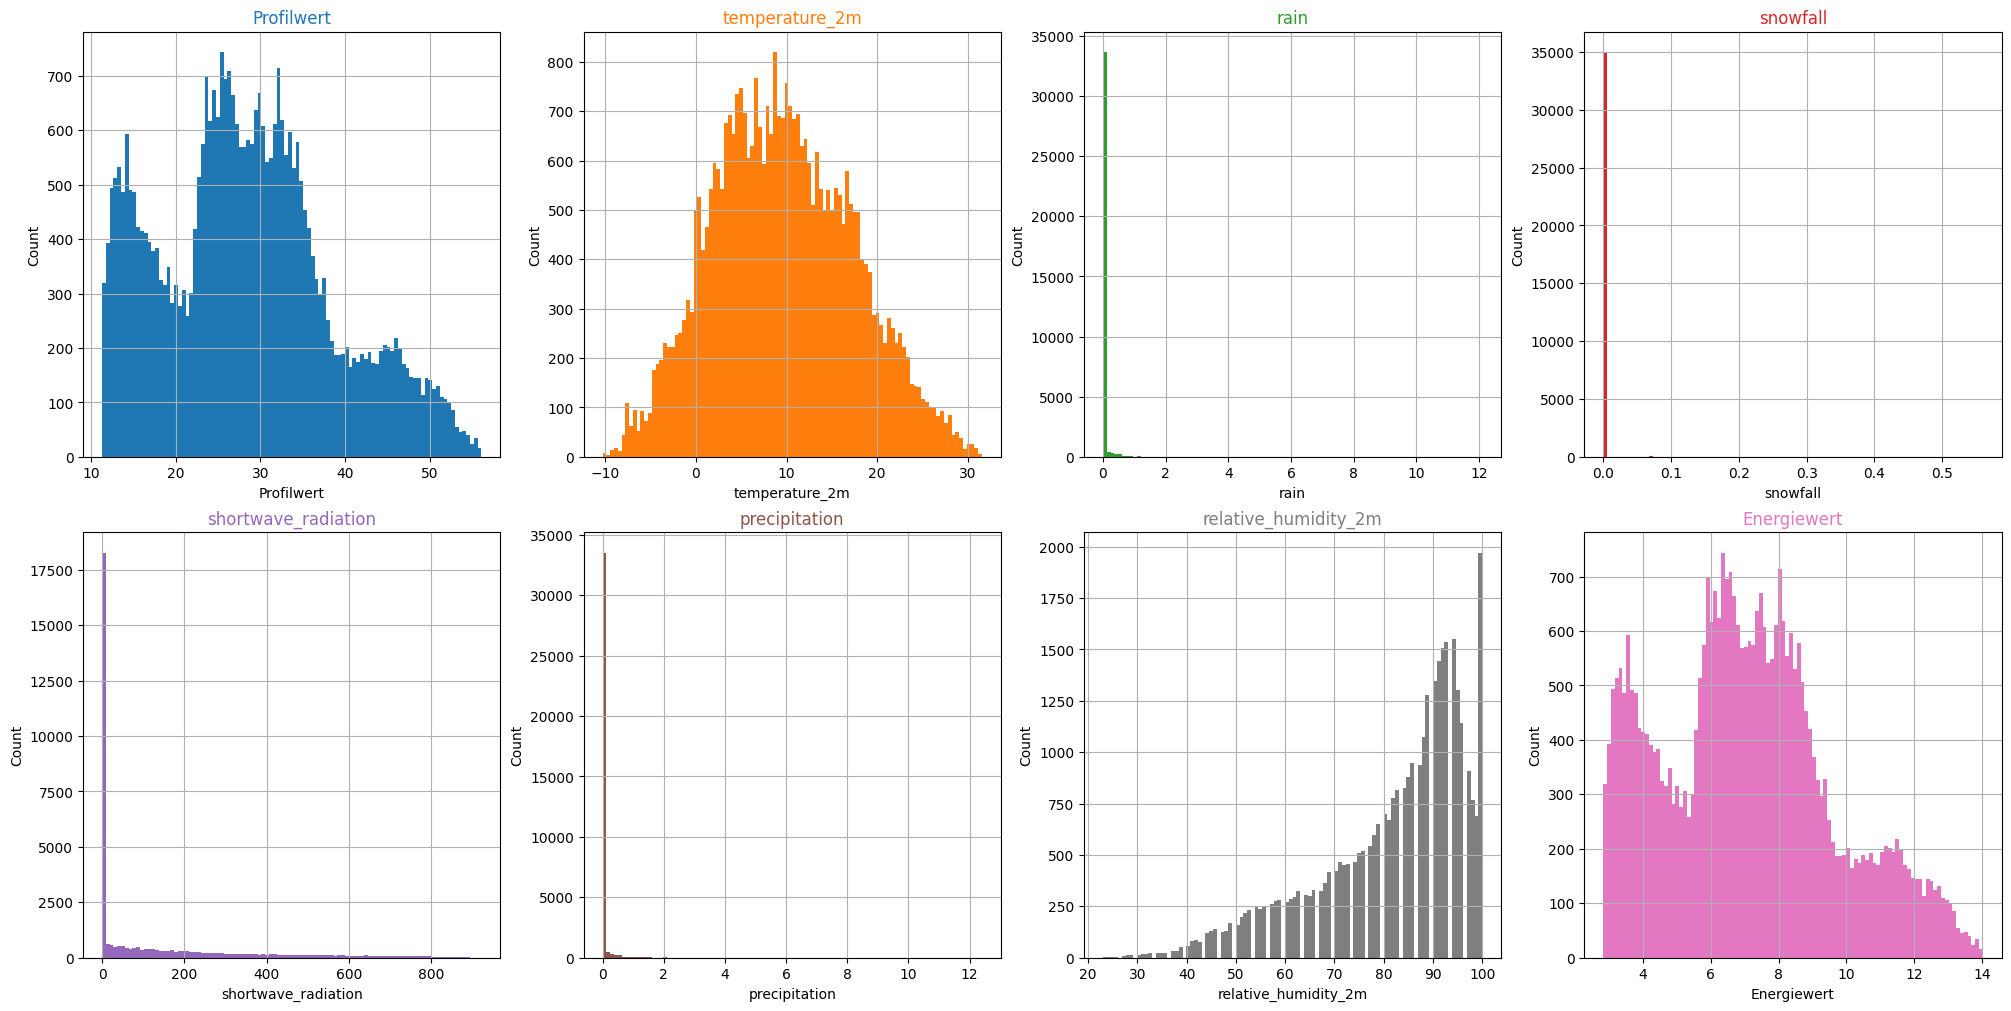

In [14]:
# Define one color per column
color_map = {
    'Profilwert':             'tab:blue',
    'temperature_2m':         'tab:orange',
    'rain':                   'tab:green',
    'snowfall':               'tab:red',
    'shortwave_radiation':    'tab:purple',
    'precipitation':          'tab:brown',
    'relative_humidity_2m':   'tab:gray',
    'Energiewert':            'tab:pink'
}

# Create figure + GridSpec for 4 top + 3 bottom histograms
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs  = fig.add_gridspec(2, 4)

axes = []
# Top row: 4 histograms
for i in range(4):
    axes.append(fig.add_subplot(gs[0, i]))
# Bottom row: 3 histograms
for i in range(4):
    axes.append(fig.add_subplot(gs[1, i]))
# Hide the last empty slot
ax_empty = fig.add_subplot(gs[1, 3])
ax_empty.axis('off')

# Plot histograms
for ax, col in zip(axes, df.columns):
    ax.hist(df[col], bins=100, color=color_map[col])
    ax.set_title(f"{col}", color=color_map[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.grid(True)

plt.show()

1. **Profilwert (load)**

    - Broad, somewhat multimodal shape spanning ≈ 11–56 MW, with peaks around 20–30 MW and a right‐leaning tail up toward the summer peaks.

    - Substantial variability (σ ≈ 10 MW) reflecting strong seasonal & diurnal swings in consumption.

2. **temperature_2m**
 
    - Roughly bell-shaped from –10 °C up to 32 °C, centered near 9 °C.

    - Symmetric enough to support linear temperature–load relationships, but with clear seasonal extremes.

3. **rain**

    - Over 80 % of slots at zero, then a long right tail up to ≈ 12 mm/15 min.

    - Rain events are rare but intense when they happen—potential outliers for load effects (e.g. road-traffic slowdowns).

4. **snowfall**

    - Almost entirely zero; max ≈ 0.56 mm.

    - Snow is very infrequent in 15-min buckets, so may have minimal direct impact on overall load.

5. **shortwave_radiation**

    - Very heavy mass at zero (nighttime), then a declining tail into the high hundreds (sunny mid-days up to ~920 W/m²).

    - Diurnal solar signal is stark—key for any PV-injection or cooling-load modeling.

6. **precipitation**

    - Mirrors rain/snowfall: predominately zero with sparse heavy events to ≈ 12 mm.

    - You’ll probably treat this like “rain” for feature engineering (e.g. binary rain/no-rain flags).

7. **relative_humidity_2m**

    - Skewed toward the top (most values 70–100 %), with a long tail down to ~23 %.

    - High humidity is the norm; low-humidity intervals are outliers (dry winter days).

#### 2. Year wide plot

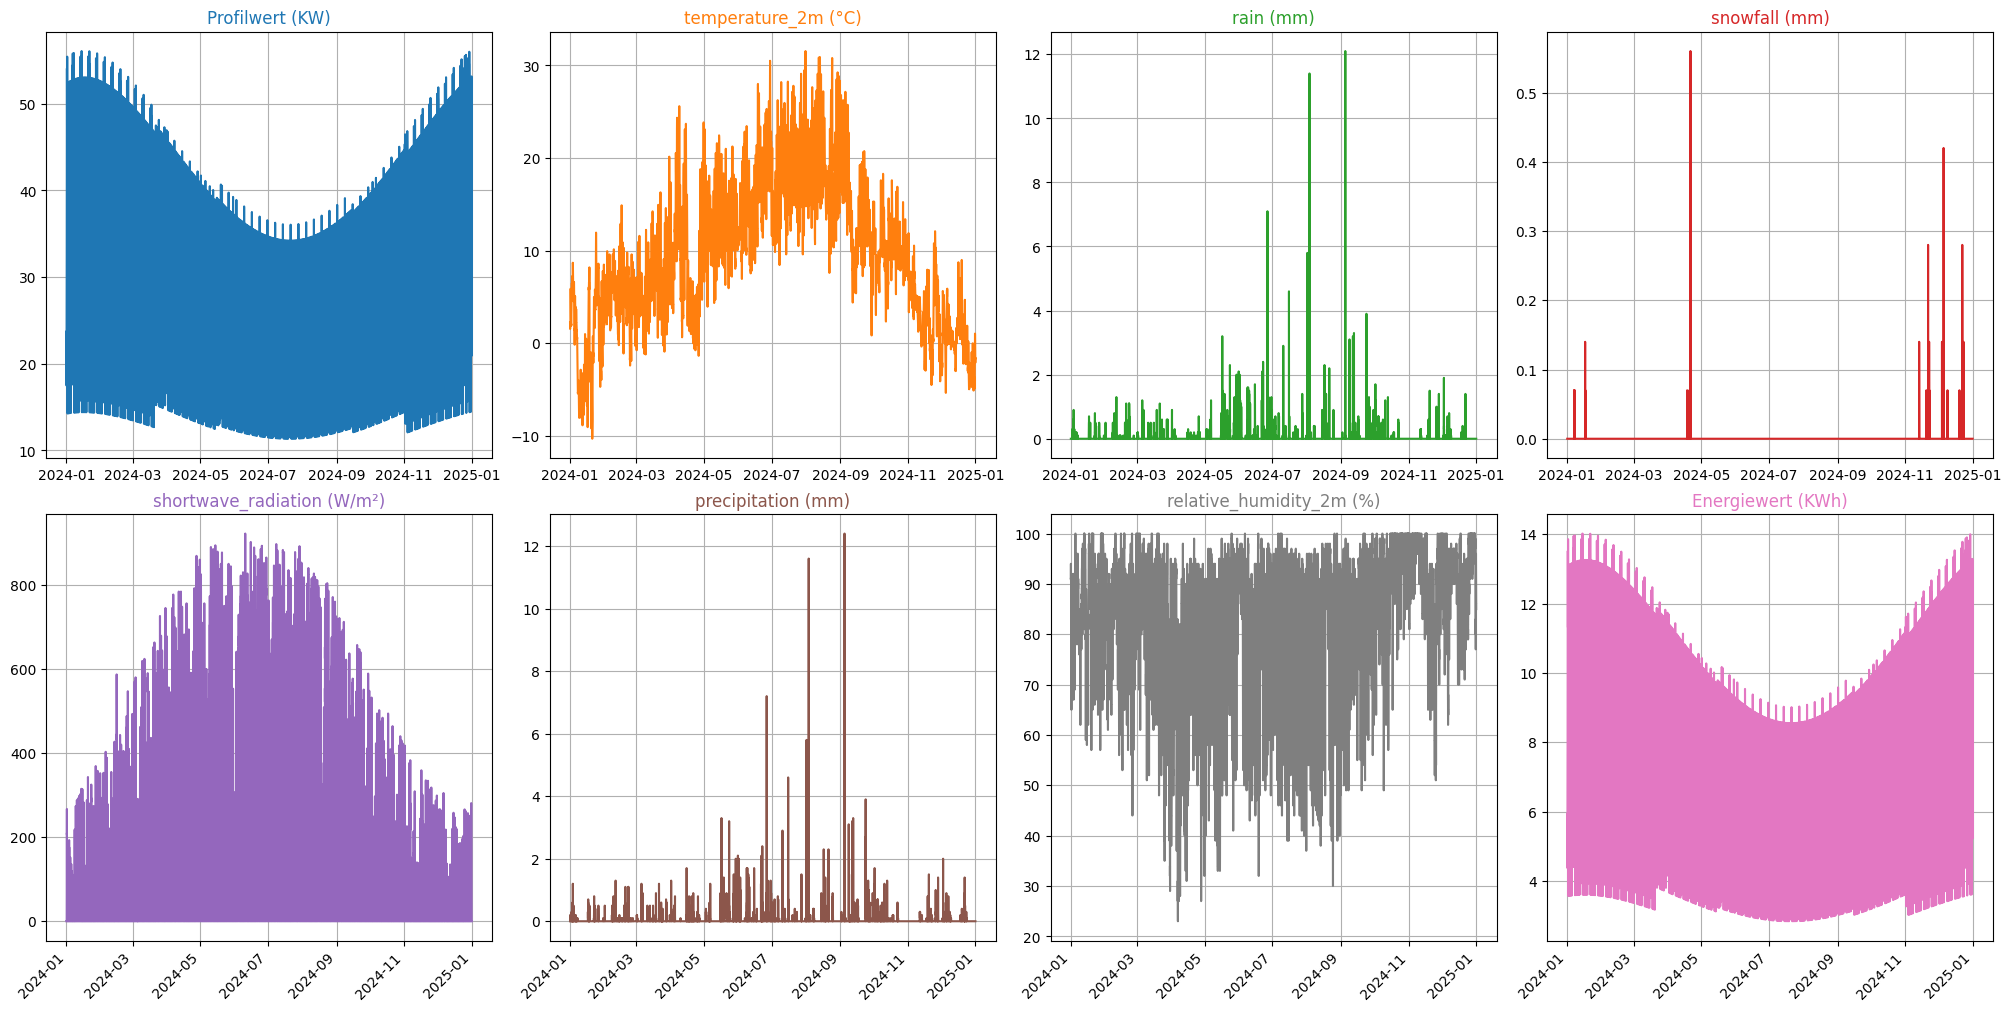

In [15]:
# Units (as before)
units = {
    'Profilwert':                'KW',
    'temperature_2m':            '°C',
    'rain':                      'mm',
    'snowfall':                  'mm',
    'shortwave_radiation':       'W/m²',
    'precipitation':             'mm',
    'relative_humidity_2m':      '%',
    'Energiewert':                'KWh'
}

# Create the 2×4 GridSpec layout
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs  = fig.add_gridspec(2, 4)

axes = []
for i in range(4):                  # top row
    axes.append(fig.add_subplot(gs[0, i]))
for i in range(4):                  # bottom row
    axes.append(fig.add_subplot(gs[1, i]))
# hide last empty slot
ax_empty = fig.add_subplot(gs[1, 3])
ax_empty.axis('off')

# Plot each series with its assigned color
for ax, col in zip(axes, df.columns):
    ax.plot(df.index, df[col], color=color_map[col])
    ax.set_title(f"{col} ({units[col]})", color=color_map[col])
    ax.grid(True)

# Rotate bottom x‐labels
for ax in axes[4:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


#### Adding Temporal features

These features are added to get the better insight of the load profile behaviour over the year

In [35]:
df['hour']       = df.index.hour
df['day']        = df.index.day
df['weekday']    = df.index.dayofweek        # Monday=0 … Sunday=6
df['month']      = df.index.month
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# 2) Part of day mapping
def hour_to_part(hour):
    if 5  <= hour < 12: return 'morning'
    if 12 <= hour < 17: return 'afternoon'
    if 17 <= hour < 21: return 'evening'
    return 'night'

df['part_of_day'] = df['hour'].map(hour_to_part)

# 3) Season map
def month_to_season(m):
    if m in (12, 1, 2):  return 'winter'
    if m in (3, 4, 5):   return 'spring'
    if m in (6, 7, 8):   return 'summer'
    return 'autumn'

df['season'] = pd.Categorical(
    df['month'].map(month_to_season),
    categories=['winter','spring','summer','autumn'],
    ordered=True
)

In [36]:
df

,Profilwert,temperature_2m,rain,snowfall,shortwave_radiation,precipitation,relative_humidity_2m,Energiewert,hour,day,weekday,month,is_weekend,season,part_of_day
Datetime,,,,,,,,,,,,,,,
2024-01-01 00:00:00,23.694512,2.25,0.0,0.0,0.0,0.0,91.0,5.923628,0,1,0,1,0,winter,night
2024-01-01 00:15:00,22.848912,2.15,0.0,0.0,0.0,0.0,91.0,5.712228,0,1,0,1,0,winter,night
2024-01-01 00:30:00,21.983059,2.00,0.0,0.0,0.0,0.0,92.0,5.495765,0,1,0,1,0,winter,night
2024-01-01 00:45:00,20.847575,1.85,0.0,0.0,0.0,0.0,93.0,5.211894,0,1,0,1,0,winter,night
2024-01-01 01:00:00,19.837413,1.75,0.0,0.0,0.0,0.0,93.0,4.959353,1,1,0,1,0,winter,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:45:00,26.837842,-1.60,0.0,0.0,0.0,0.0,86.0,6.709461,22,31,1,12,0,winter,night
2024-12-31 23:00:00,26.930280,-1.60,0.0,0.0,0.0,0.0,86.0,6.732570,23,31,1,12,0,winter,night
2024-12-31 23:15:00,25.317750,-1.60,0.0,0.0,0.0,0.0,86.0,6.329438,23,31,1,12,0,winter,night


#### Average 24-h load profile for each weekday

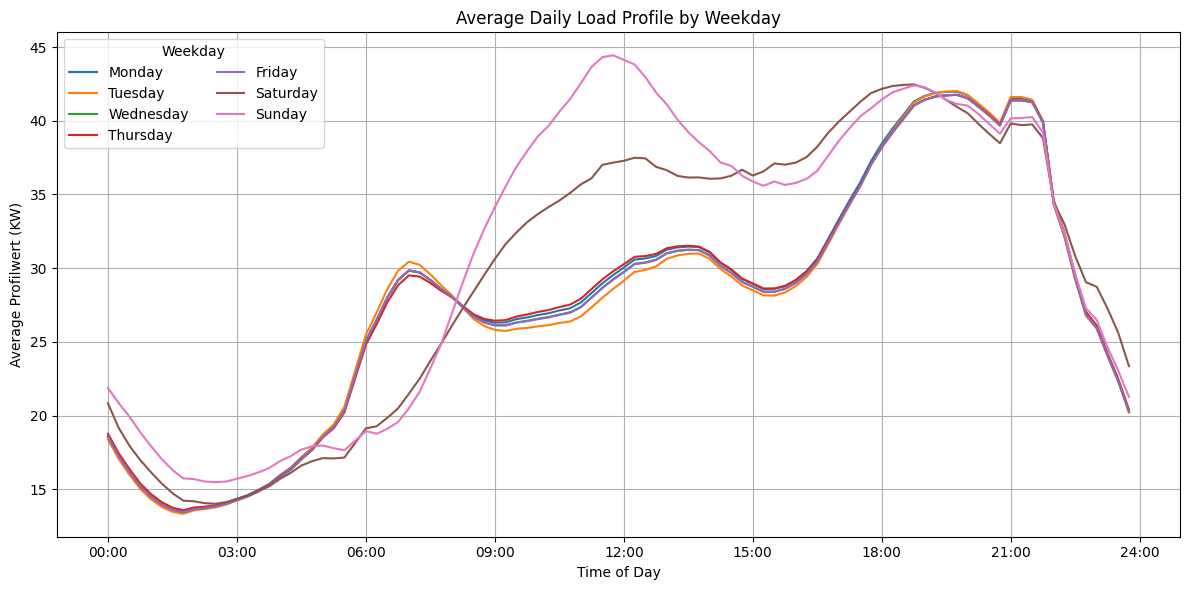

In [37]:
# 1) Compute the mean daily profile by weekday/time
times = df.index.time
mean_profiles = (
    df
    .assign(time=times)
    .groupby(['weekday', 'time'])['Profilwert']
    .mean()
    .unstack(level=0)
)

# 2) Rename columns to names
weekday_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mean_profiles.columns = weekday_names

# 3) Convert the time index to numeric hours
time_hours = [t.hour + t.minute/60 for t in mean_profiles.index]

# 4) Plot
plt.figure(figsize=(12,6))
for wd in weekday_names:
    plt.plot(time_hours, mean_profiles[wd], label=wd)

# 5) Make nice x‐ticks at e.g. every 3 hours
hour_ticks = list(range(0,25,3))
plt.xticks(hour_ticks, [f"{h:02d}:00" for h in hour_ticks])

plt.xlabel('Time of Day')
plt.ylabel('Average Profilwert (KW)')
plt.title('Average Daily Load Profile by Weekday')
plt.legend(title='Weekday', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Weekday vs Weekend

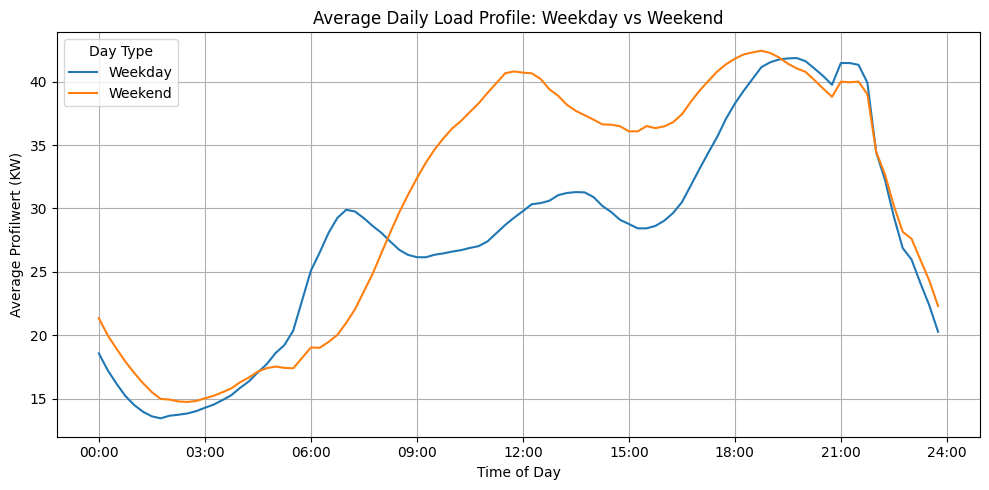

In [38]:
# 1) Compute mean daily profile for weekday vs weekend
mean_profiles = (
    df
    .assign(time=df.index.time)
    .groupby(['is_weekend', 'time'])['Profilwert']
    .mean()
    .unstack(level=0)  # columns: 0 = weekday, 1 = weekend
)

# 2) Convert time index to numeric hours
time_hours = [t.hour + t.minute/60 for t in mean_profiles.index]

# 3) Plot both profiles
plt.figure(figsize=(10, 5))
plt.plot(time_hours, mean_profiles[0], label='Weekday', color='tab:blue')
plt.plot(time_hours, mean_profiles[1], label='Weekend', color='tab:orange')

# 4) Format x‐axis
hour_ticks = list(range(0, 25, 3))
plt.xticks(hour_ticks, [f"{h:02d}:00" for h in hour_ticks])

plt.xlabel('Time of Day')
plt.ylabel('Average Profilwert (KW)')
plt.title('Average Daily Load Profile: Weekday vs Weekend')
plt.legend(title='Day Type')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Month wise average Daily plot

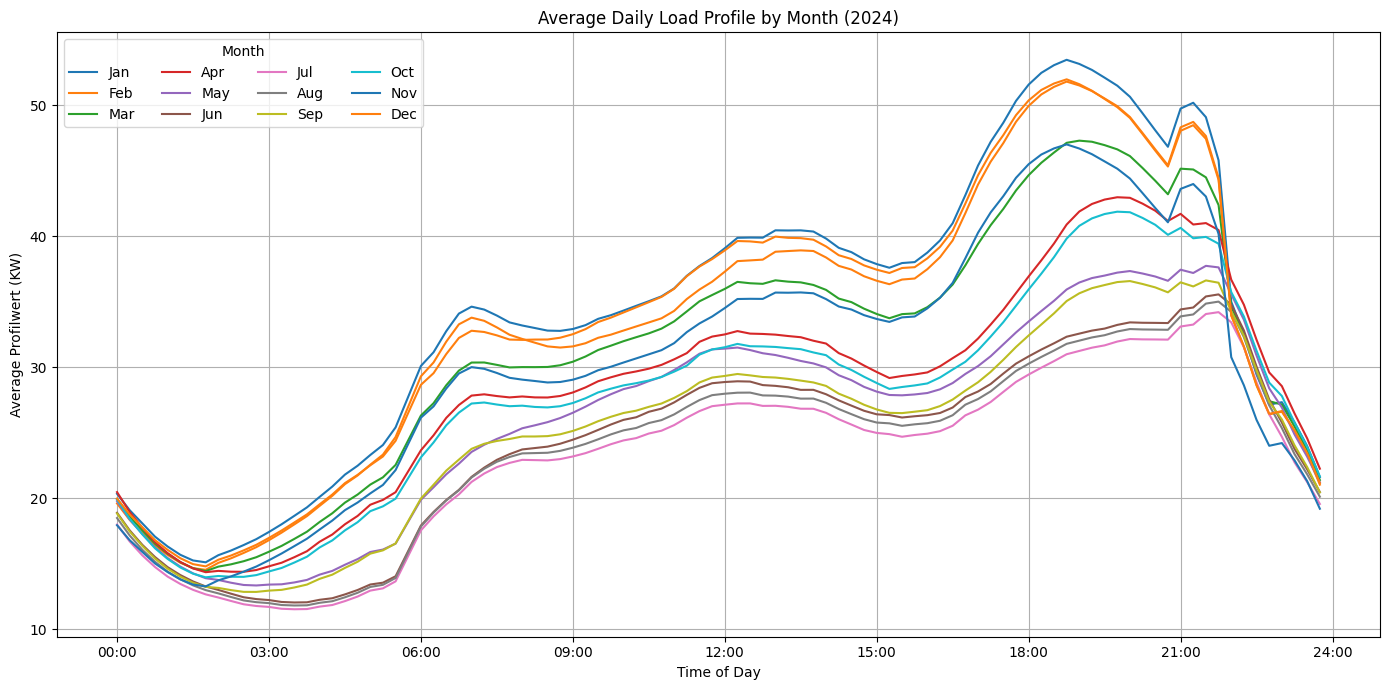

In [39]:
import calendar

# 1) Compute mean profile by month & time of day
profiles = (
    df
    .assign(time=df.index.time)
    .groupby([df.index.month, 'time'])['Profilwert']
    .mean()
    .unstack(level=0)   # columns = 1…12
)

# 2) Convert time index to numeric hours
time_hours = [t.hour + t.minute/60 for t in profiles.index]

# 3) Plot all 12 month-curves
plt.figure(figsize=(14, 7))
for m in range(1, 13):
    plt.plot(
        time_hours,
        profiles[m],
        label=calendar.month_abbr[m]
    )

# 4) Format x-axis as hours
hour_ticks = list(range(0, 25, 3))
plt.xticks(hour_ticks, [f"{h:02d}:00" for h in hour_ticks])

plt.xlabel('Time of Day')
plt.ylabel('Average Profilwert (KW)')
plt.title('Average Daily Load Profile by Month (2024)')
plt.legend(title='Month', ncol=4)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Season wise average Daily plot

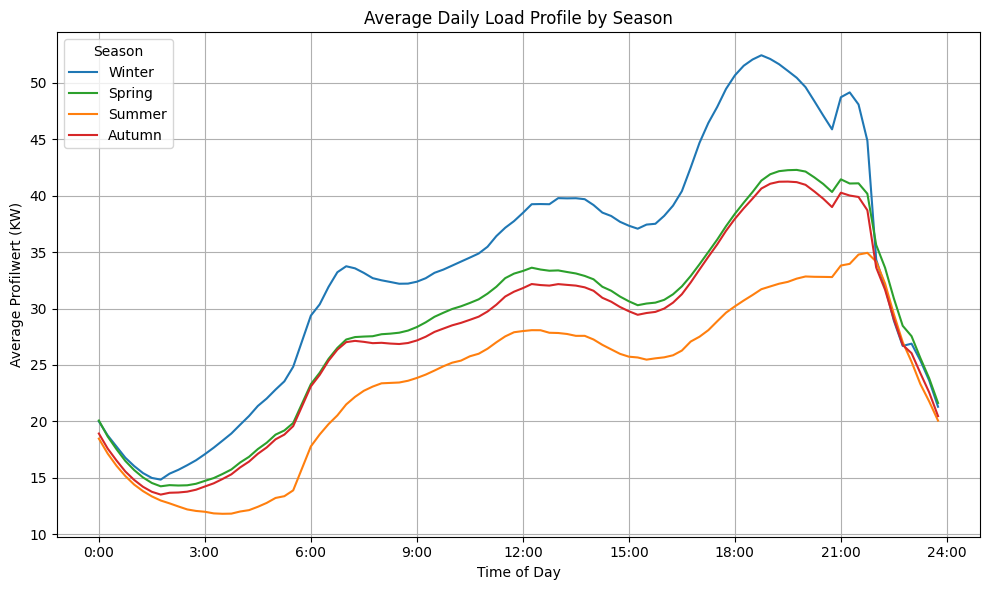

In [21]:
# 1) Compute mean daily profile by season & time of day
profiles = (
    df
    .assign(time=df.index.time)
    .groupby(['season', 'time'])['Profilwert']
    .mean()
    .unstack(level=0)  # columns = seasons: winter, spring, summer, autumn
)

# 2) Convert time index to numeric hours
time_hours = [t.hour + t.minute/60 for t in profiles.index]

# 3) Define a color for each season
season_colors = {
    'winter': 'tab:blue',
    'spring': 'tab:green',
    'summer': 'tab:orange',
    'autumn': 'tab:red'
}

# 4) Plot all season-curves
plt.figure(figsize=(10, 6))
for season, color in season_colors.items():
    plt.plot(
        time_hours,
        profiles[season],
        label=season.capitalize(),
        color=color
    )

# 5) Format x-axis as hours
hour_ticks = list(range(0, 25, 3))
plt.xticks(hour_ticks, [f"{h:01d}:00" for h in hour_ticks])

plt.xlabel('Time of Day')
plt.ylabel('Average Profilwert (KW)')
plt.title('Average Daily Load Profile by Season')
plt.legend(title='Season')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Energie Consumption for each part of the day 

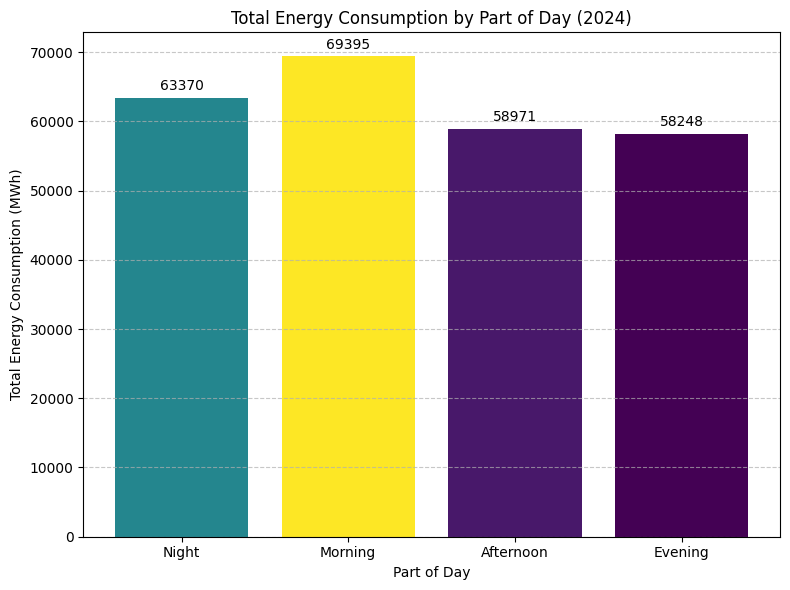

In [43]:
# 1) Sum energy by part_of_day
energy_by_pod = df.groupby('part_of_day')['Energiewert'].sum()

# 2) Define order of parts of day
pod_order = ['night', 'morning', 'afternoon', 'evening']
energy_by_pod = energy_by_pod.reindex(pod_order)

# 3) Capitalize labels for display
labels = [pod.capitalize() for pod in energy_by_pod.index]

# 4) Normalize values for color mapping
norm = mcolors.Normalize(vmin=energy_by_pod.min(), vmax=energy_by_pod.max())
cmap = cm.get_cmap('viridis')
colors = cmap(norm(energy_by_pod.values))

# 5) Plot bar chart with gradient colors
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, energy_by_pod.values, color=colors)

# 6) Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * energy_by_pod.max(),
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )

# 7) Formatting
ax.set_xlabel('Part of Day')
ax.set_ylabel('Total Energy Consumption (MWh)')
ax.set_title('Total Energy Consumption by Part of Day (2024)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Morning peak: At ~69 395 MWh, mornings see the highest demand—about 11 100 MWh (≈16 %) above evenings and 5 000 MWh (≈8 %) above nights.

- Evening low: Evenings register the lowest consumption (≈58 248 MWh), just ~1 200 MWh (~2 %) below afternoons.

- Night plateau: Nights hold second place (≈63 370 MWh), ~9 % below the morning high.

- Midday lull: Afternoon demand dips to ~58 971 MWh—a ~15 % drop from the morning peak.

- Sharp morning ramp: The jump from night to morning (+6 025 MWh, ~9 %) underscores the start‐of‐day activity surge.

- Model cue: A simple “part‐of‐day” categorical feature (especially flagging mornings) will capture most of this intraday seasonality.

#### Energie Consumption for each day of the week

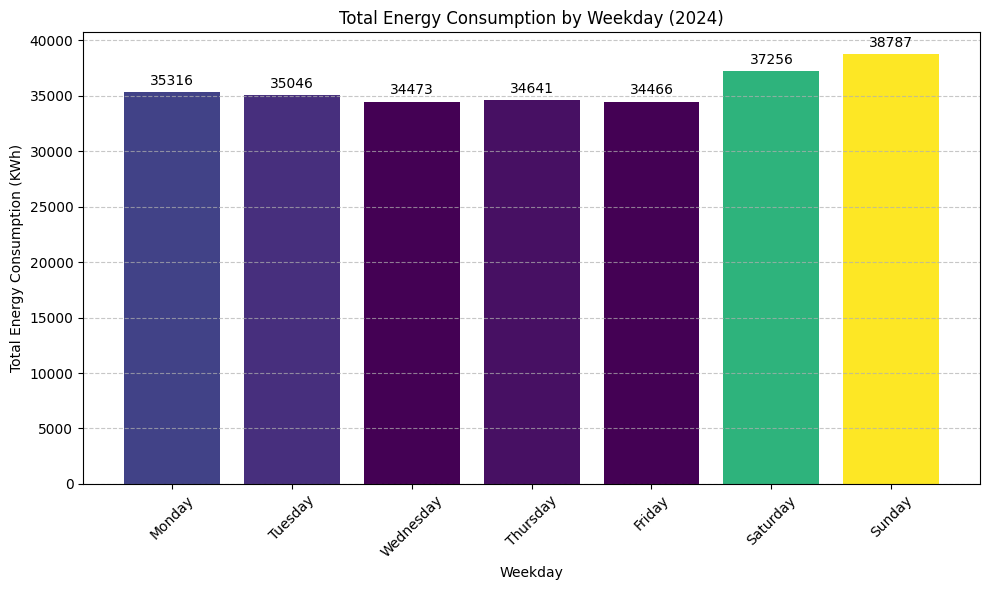

In [41]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# 1) Sum energy by weekday
energy_by_weekday = df.groupby('weekday')['Energiewert'].sum()

# 2) Map weekday number to name
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
energy_by_weekday.index = [weekday_names[i] for i in energy_by_weekday.index]

# 3) Normalize values for color mapping
norm = mcolors.Normalize(vmin=energy_by_weekday.min(), vmax=energy_by_weekday.max())
cmap = cm.get_cmap('viridis')

# 4) Assign colors based on normalized values
colors = cmap(norm(energy_by_weekday.values))

# 5) Plot bar chart with gradient colors
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(energy_by_weekday.index, energy_by_weekday.values, color=colors)

# 6) Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * energy_by_weekday.max(),
            f'{height:.0f}', ha='center', va='bottom')

# 7) Formatting
ax.set_xlabel('Weekday')
ax.set_ylabel('Total Energy Consumption (KWh)')
ax.set_title('Total Energy Consumption by Weekday (2024)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Sunday tops out at 38 787 kWh—the highest of the week.

- Friday bottoms out at 34 466 kWh—the lowest single‐day total.

- Weekend uplift: Saturday (37 256) and Sunday are ~7 000 kWh (+20%) above the weekday average (~34 840).

- Weekday flatness: Monday–Friday vary only ~2 850 kWh (<8%), with Wednesday the weekday low (34 473).

- Monday high‐mark: Among weekdays, Monday’s 35 316 kWh is ~3% above the Friday minimum.

- Model tip: A simple “weekend vs. weekday” categorical feature will capture most of this day-of-week seasonality.

#### Energie Consumption Weekday Vs. Weekend

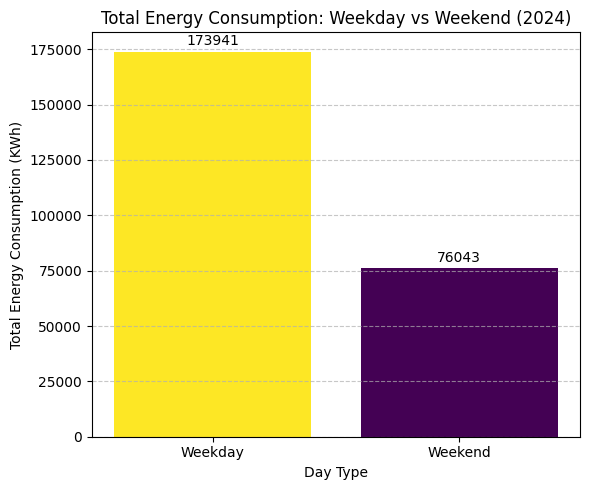

In [42]:
# 1) Sum energy by is_weekend
energy_by_weektype = df.groupby('is_weekend')['Energiewert'].sum()

# 2) Map index to names
energy_by_weektype.index = energy_by_weektype.index.map({0: 'Weekday', 1: 'Weekend'})

# 3) Normalize values for color mapping
norm = mcolors.Normalize(vmin=energy_by_weektype.min(), vmax=energy_by_weektype.max())
cmap = cm.get_cmap('viridis')

# 4) Assign colors based on normalized values
colors = cmap(norm(energy_by_weektype.values))

# 5) Plot bar chart with gradient colors
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(energy_by_weektype.index, energy_by_weektype.values, color=colors)

# 6) Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01 * energy_by_weektype.max(),
            f'{height:.0f}', ha='center', va='bottom')

# 7) Formatting
ax.set_xlabel('Day Type')
ax.set_ylabel('Total Energy Consumption (KWh)')
ax.set_title('Total Energy Consumption: Weekday vs Weekend (2024)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Energie Consumption Month-wise

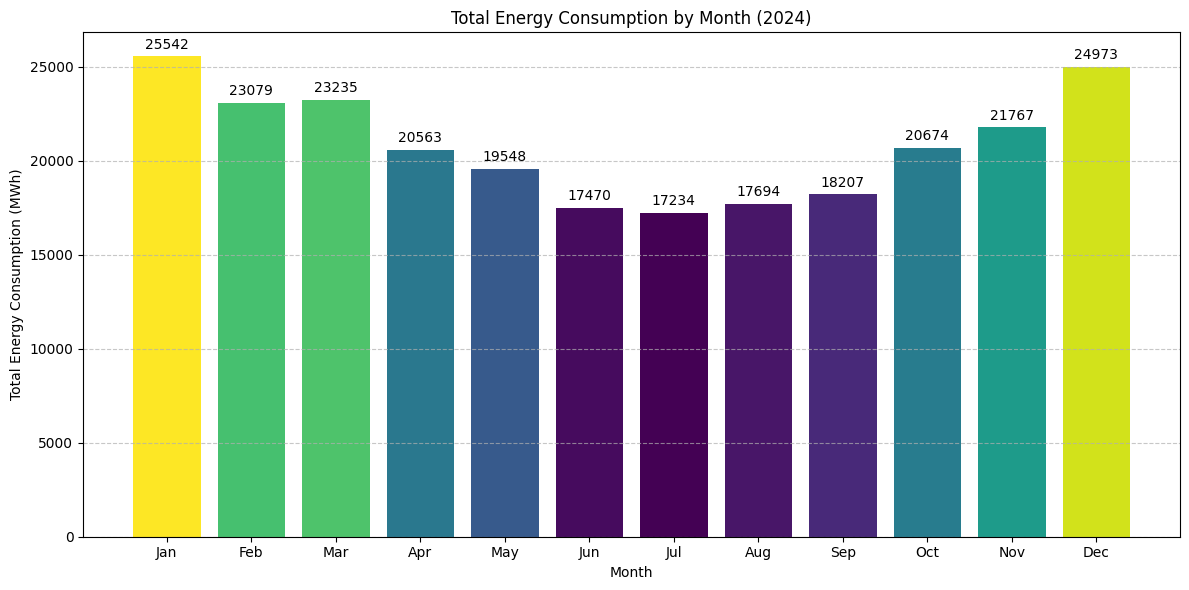

In [33]:
# 1) Sum energy by month
energy_by_month = df.groupby('month')['Energiewert'].sum()

# 2) Map month number to abbreviated name
month_names = [calendar.month_abbr[m] for m in energy_by_month.index]
energy_by_month.index = month_names

# 4) Normalize values for color mapping
norm = mcolors.Normalize(vmin=energy_by_month.min(), vmax=energy_by_month.max())
cmap = cm.get_cmap('viridis')
colors = cmap(norm(energy_by_month.values))

# 5) Plot bar chart with gradient colors
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(energy_by_month.index, energy_by_month.values, color=colors)

# 6) Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * energy_by_month.max(),
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )

# 7) Formatting
ax.set_xlabel('Month')
ax.set_ylabel('Total Energy Consumption (MWh)')
ax.set_title('Total Energy Consumption by Month (2024)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Winter high: January peaks at 25 542 MWh (highest), with December close behind at 24 973 MWh.

- Summer low: July bottoms out at 17 234 MWh—the year’s trough—joined by June (17 470) and August (17 694).

- Steep spring drop: From March (23 235) to June (17 470) demand falls ~5 765 MWh (≈25 %).

- Rapid rebound: July-to-December jump is ~7 739 MWh (+45 %).

- Autumn ramp-up: Consumption climbs steadily from September’s 18 207 to October’s 20 674.

- Seasonal driver: Heating demand drives winter peaks; summer cooling is far less intensive.

#### Energie Consumption Season-wise

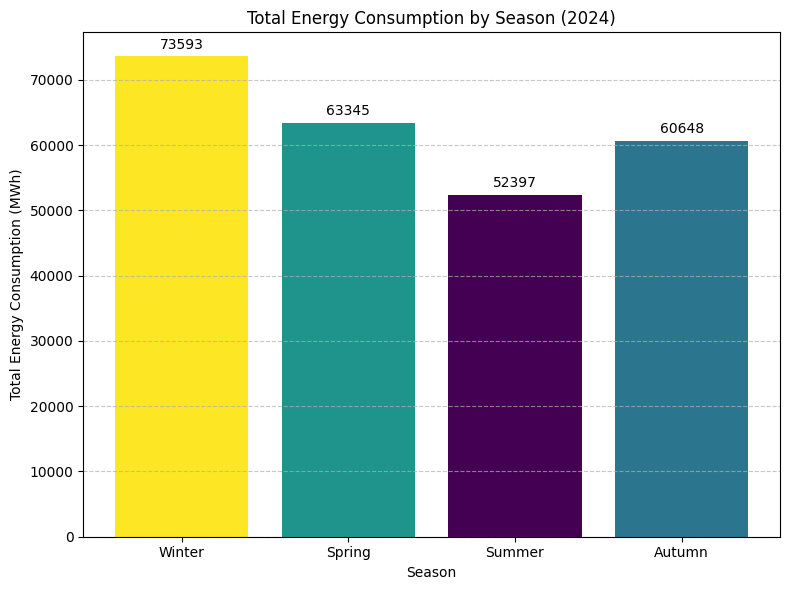

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# 1) Sum energy by season
energy_by_season = df.groupby('season')['Energiewert'].sum()
# Ensure categorical order
season_order = ['winter', 'spring', 'summer', 'autumn']
energy_by_season = energy_by_season.reindex(season_order)

# 2) Normalize for color mapping
norm = mcolors.Normalize(vmin=energy_by_season.min(), vmax=energy_by_season.max())
cmap = cm.get_cmap('viridis')
colors = cmap(norm(energy_by_season.values))

# 3) Plot bar chart with gradient colors
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(energy_by_season.index.str.capitalize(), energy_by_season.values, color=colors)

# 4) Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * energy_by_season.max(),
        f'{height:.0f}',
        ha='center',
        va='bottom'
    )

# 5) Formatting
ax.set_xlabel('Season')
ax.set_ylabel('Total Energy Consumption (MWh)')
ax.set_title('Total Energy Consumption by Season (2024)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Winter peaks at 73,593 MWh—the highest of all seasons.

- Summer bottoms out at 52,397 MWh—the lowest consumption.

- Spring sits at 63,345 MWh, ~8 GWh above summer.

- Autumn clocks in at 60,648 MWh, ~3 GWh below spring.

- Winter vs Summer gap is ~21 GWh (~40 % higher in winter).

#### Load consumption on Extreme weather conditions

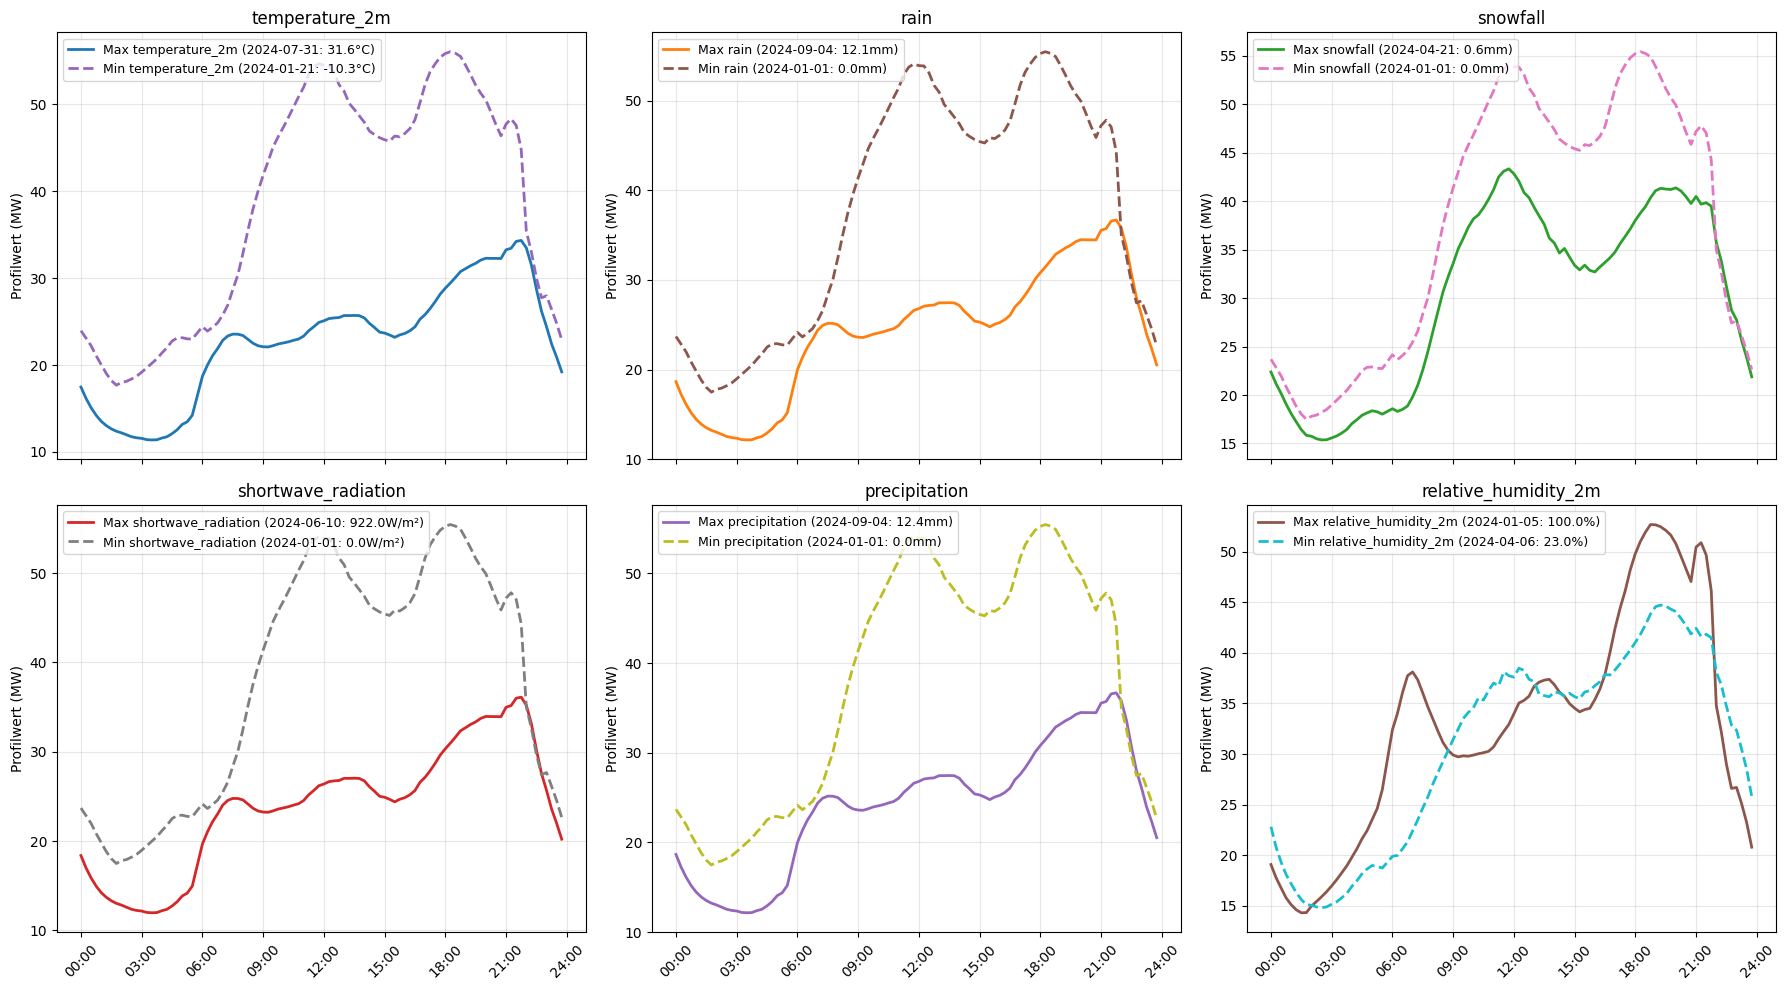

In [88]:
weather_cols = [
    'temperature_2m',
    'rain',
    'snowfall',
    'shortwave_radiation',
    'precipitation',
    'relative_humidity_2m'
]
unit_map = {
    'temperature_2m':        '°C',
    'rain':                  'mm',
    'snowfall':              'mm',
    'shortwave_radiation':   'W/m²',
    'precipitation':         'mm',
    'relative_humidity_2m':  '%'
}

# Prepare distinct colors
cmap = plt.get_cmap('tab10')
max_colors = [cmap(i)        for i in range(len(weather_cols))]
min_colors = [cmap(i + 4)    for i in range(len(weather_cols))]

to_hours = lambda idx: [t.hour + t.minute/60 for t in idx.time]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, col in enumerate(weather_cols):
    ax = axes[i]
    # find extreme timestamps
    max_idx = df[col].idxmax()
    min_idx = df[col].idxmin()
    max_date, min_date = max_idx.date(), min_idx.date()
    max_val = df.loc[max_idx, col]
    min_val = df.loc[min_idx, col]
    # extract the full-day load
    prof_max = df.loc[str(max_date), 'Profilwert']
    prof_min = df.loc[str(min_date), 'Profilwert']
    hrs_max  = to_hours(prof_max.index)
    hrs_min  = to_hours(prof_min.index)
    # plot
    ax.plot(hrs_max, prof_max.values,
            label=f"Max {col} ({max_date}: {max_val:.1f}{unit_map[col]})",
            color=max_colors[i], lw=2)
    ax.plot(hrs_min, prof_min.values,
            label=f"Min {col} ({min_date}: {min_val:.1f}{unit_map[col]})",
            color=min_colors[i], lw=2, linestyle='--')
    # formatting
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Profilwert (MW)')
    ax.set_xticks(range(0,25,3))
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0,25,3)], rotation=45)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)

# remove any unused axes (in case weather_cols < 6)
for j in range(len(weather_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Cold vs Hot: Cold days (≈–10 °C) hit ~55 MW peaks; hot days (~32 °C) barely reach ~25 MW.

- Precipitation: Rain or snow cuts output by ~15–20 MW compared to dry days.

- Sunshine: Peak output is lowest on the sunniest days (≈36 MW) and highest on overcast days (≈55 MW).

- Humidity: Very low‐humidity days show flatter diurnal curves and ~10 MW lower peaks than high‐humidity days.

- Diurnal Shape: All conditions preserve the twin morning/evening bump pattern.

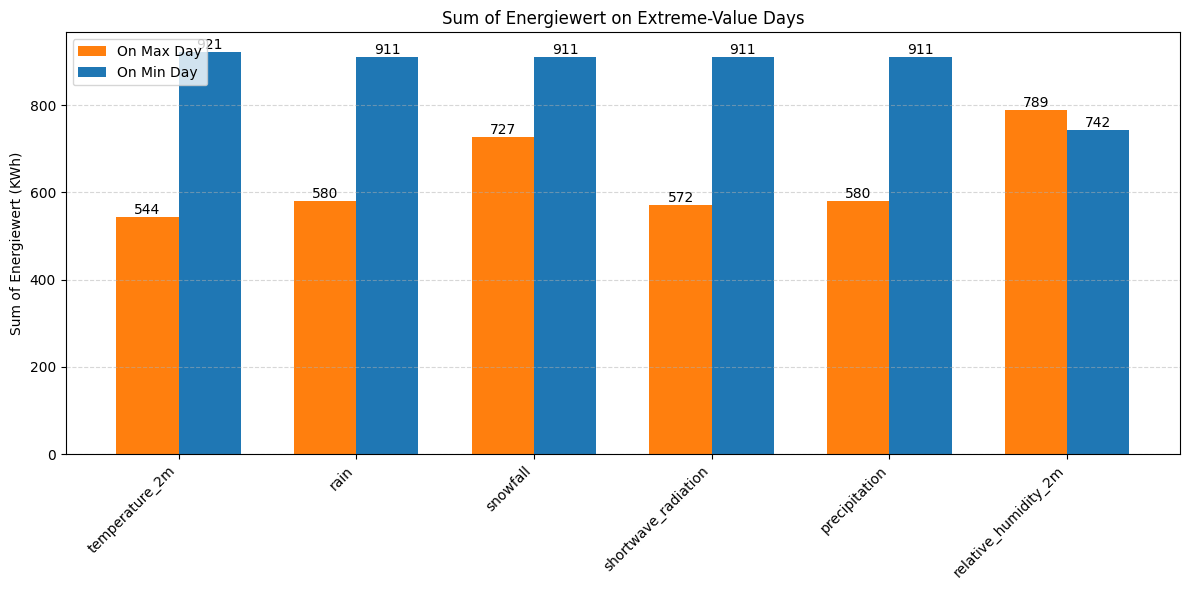

In [90]:
weather_cols = [
    'temperature_2m',
    'rain',
    'snowfall',
    'shortwave_radiation',
    'precipitation',
    'relative_humidity_2m'
]

# 1) Compute sums of Energiewert for each extreme day
max_sums = []
min_sums = []
for col in weather_cols:
    # find extreme dates
    date_max = df[col].idxmax().date()
    date_min = df[col].idxmin().date()
    # sum Energiewert over those full days
    sum_max = df.loc[str(date_max), 'Energiewert'].sum()
    sum_min = df.loc[str(date_min), 'Energiewert'].sum()
    max_sums.append(sum_max)
    min_sums.append(sum_min)

# 2) Plot grouped bars
x = np.arange(len(weather_cols))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars_max = ax.bar(x - width/2, max_sums, width, label='On Max Day', color='tab:orange')
bars_min = ax.bar(x + width/2, min_sums, width, label='On Min Day', color='tab:blue')

# 3) Annotate bars
for bar in bars_max + bars_min:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h,
            f'{h:.0f}', ha='center', va='bottom')

# 4) Formatting
ax.set_xticks(x)
ax.set_xticklabels(weather_cols, rotation=45, ha='right')
ax.set_ylabel('Sum of Energiewert (KWh)')
ax.set_title('Sum of Energiewert on Extreme-Value Days')
ax.legend(loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

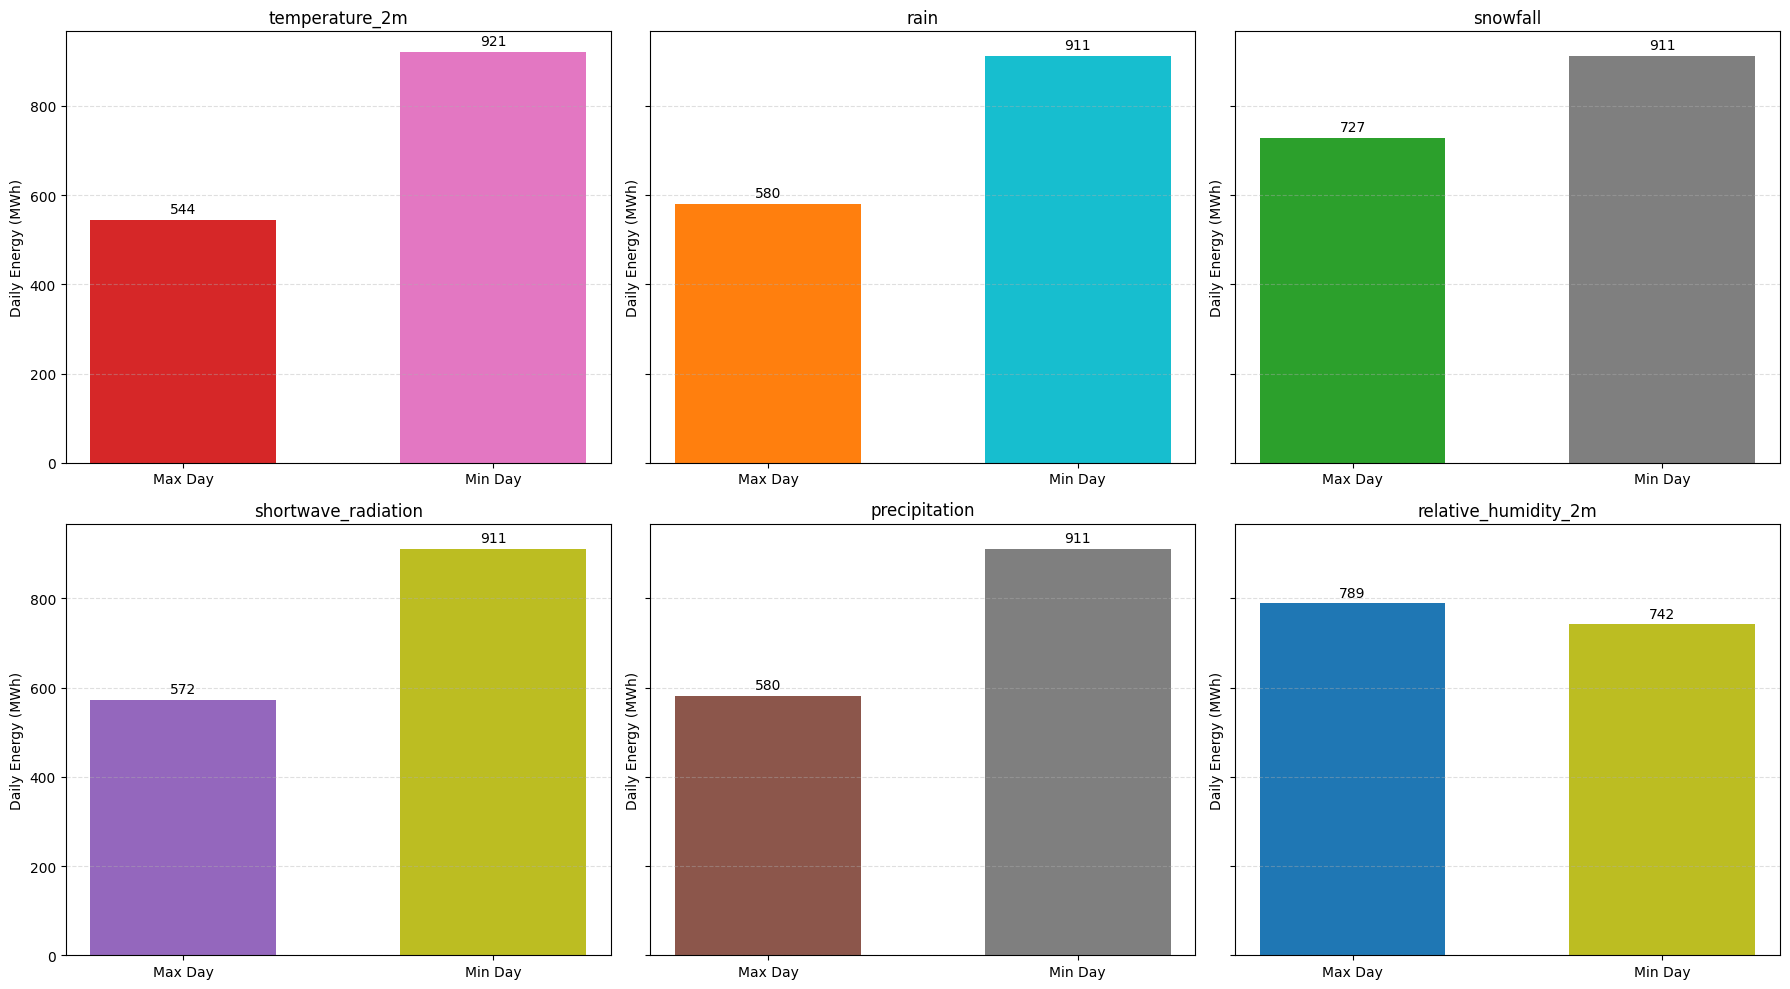

In [101]:
import matplotlib.pyplot as plt

weather_cols = [
    'temperature_2m',
    'rain',
    'snowfall',
    'shortwave_radiation',
    'precipitation',
    'relative_humidity_2m'
]

# Pick valid "tab:" colors for max/min bars
max_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:blue']
min_colors = ['tab:pink','tab:cyan',   'tab:gray',  'tab:olive',  'tab:grey',  'tab:olive']

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

for i, col in enumerate(weather_cols):
    ax = axes[i]
    
    # 1) find extreme dates
    d_max = df[col].idxmax().date()
    d_min = df[col].idxmin().date()
    
    # 2) sum daily energy (Energiewert)
    s_max = df.loc[str(d_max), 'Energiewert'].sum()
    s_min = df.loc[str(d_min), 'Energiewert'].sum()
    
    # 3) plot both bars in one call
    bars = ax.bar(
        ['Max Day', 'Min Day'],
        [s_max, s_min],
        color=[max_colors[i], min_colors[i]],
        width=0.6
    )
    
    # 4) annotate
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.01 * max(s_max, s_min),
            f'{h:.0f}',
            ha='center',
            va='bottom'
        )
    
    # 5) formatting
    ax.set_title(col, fontsize=12)
    ax.set_ylabel('Daily Energy (MWh)')
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# remove any unused subplots (if any)
for j in range(len(weather_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
